This notebook is run on my personal computer to extract the data. Each nii file has roughly two parts. The first part is the 3D array, and the second part the ''header'', which contains technical information about the MRI images. The default type of the data, which is uint16, is learned from the header, but other technical info is simply abandoned. 

Among the FZMC001~FZMC040 + FZMC042 datasets, FZMC038 has no ''label.nii'', and is deleted and replaced by FZMC042. Thus we have 40 observations in total.

The raw data of the 40 obs is rearranged into 5 arrays, all in the shape of $40*320*260*72$.

Dimensional mismatch is frequently observed in the data. For example, for no. 5,6,16,39, 'artery' and 'label' has different shapes. Since we will mainly focus on the artery phase, these 4 obs are deleted. However, 'delay' is especially problematic: FZMC003 has one more mismatch in ''delay.nii''. Since our main focus may be the artery phase, ''delay'' is not included in the arrays.

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img = nib.load('../data/raw/FZMC001/artery.nii')

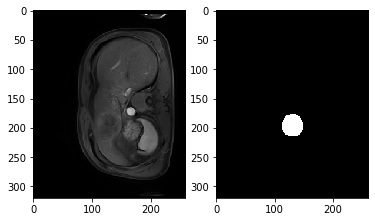

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img.get_fdata(dtype=np.float64)[:,:,50],cmap='gray')
ax2.imshow(nib.load('../data/raw/FZMC001/label.nii').get_fdata(dtype=np.float64)[:,:,50],cmap='gray')

In [4]:
j='artery'
A = np.zeros((36, 320, 260, 72), dtype=np.uint16)
ptr = 0
for i in range(1, 41):
    if i in (5,6,16,39):
        continue
    A[ptr,:,:,:] = np.asarray(nib.load('../data/raw/FZMC0{:02d}/{}.nii'\
                                       .format(i,j)).get_fdata(), dtype=np.uint16).copy()
    ptr += 1
np.save("{}.npy".format(j),A)

In [5]:
j='label'
L = np.zeros((36, 320, 260, 72), dtype=np.uint16)
ptr = 0
for i in range(1, 41):
    if i in (5,6,16,39):
        continue
    L[ptr,:,:,:] = np.asarray(nib.load('../data/raw/FZMC0{:02d}/{}.nii'\
                                       .format(i,j)).get_fdata(), dtype=np.uint16).copy()
    ptr += 1
np.save("{}.npy".format(j),L)

In [6]:
img_artery = nib.load('../data/raw/FZMC003/artery.nii')
img_delay = nib.load('../data/raw/FZMC003/delay.nii')

### Load Data
- load numpy arrays
- convert into Dataset, perform transformation
- split into training set and testing set
- place into DataLoader

In [7]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [8]:
#---Load Data---#

# artery = np.load('../data/artery.npy')
artery = A

In [9]:
# label = np.load('../data/label.npy')
label = L

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(np.array(data, dtype='int32'))
        self.target = torch.from_numpy(np.array(target, dtype='int32'))
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
        
    def __len__(self):
        return len(self.data)

In [11]:
dataset = MyDataset(artery, label)

In [12]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,\
                                        shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,\
                                        shuffle=True, num_workers=0)

### Create Network
- Convolution blocks (contraction) -> Up blocks (expansive)
- 3 x 3 convolution
- ReLU as activation function
- 2 x 2 max pooling with stride of 2
- channels: 1 -> 64 -> 128 -> 256 -> 128 -> 64 -> 1
- soft max applied to final feature map

In [14]:
#---Create Network---#

class ConvBlock(nn.Module):    
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu):      
        super(ConvBlock, self).__init__()        
        self.conv = nn.Conv3d(in_size, out_size, kernel_size)
        self.conv2 = nn.Conv3d(out_size, out_size, kernel_size)
        self.activation = activation

    def forward(self, x):
        out = self.activation(self.conv(x))
        out = self.activation(self.conv2(out))
        return out


class UpBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, space_dropout=False):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose3d(in_size, out_size, 2, stride=2)
        self.conv = nn.Conv3d(in_size, out_size, kernel_size)
        self.conv2 = nn.Conv3d(out_size, out_size, kernel_size)
        self.activation = activation

    def center_crop(self, layer, target_size):
        batch_size, n_channels, layer_width, layer_height = layer.size()
        base = (layer_width - target_size) // 2
        return layer[:, :, base:(base + target_size), base:(base + target_size)]

    def forward(self, x, bridge):
        up = self.up(x)
        # Crop feature maps of corresponding contraction layer to same size as current layer
        crop1 = self.center_crop(bridge, up.size()[2])
        # Append feature maps of the corresponding contraction layer
        out = torch.cat([up, crop1], 1)
        out = self.activation(self.conv(out))
        out = self.activation(self.conv2(out))
        return out


class UNet(nn.Module):
    def __init__(self):        
        super(UNet, self).__init__()
        self.activation = F.relu        
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.MaxPool3d(2)
        self.pool3 = nn.MaxPool3d(2)
        self.conv_block1_64 = ConvBlock(1, 64)
        self.conv_block64_128 = ConvBlock(64, 128)
        self.conv_block128_256 = ConvBlock(128, 256)
        self.up_block256_128 = UpBlock(256, 128)
        self.up_block128_64 = UpBlock(128, 64)
        self.last = nn.Conv3d(64, 4, 1)

    def forward(self, x):
        block1 = self.conv_block1_64(x)
        pool1 = self.pool1(block1)
        block2 = self.conv_block64_128(pool1)
        pool2 = self.pool2(block2)
        block3 = self.conv_block128_256(pool2)
        pool3 = self.pool3(block3)
        up1 = self.up_block256_128(block3, block2)
        up2 = self.up_block128_64(up1, block1)
        return F.log_softmax(self.last(up2))

In [15]:
net = UNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_trajectory = [0]

### Train Network

In [ ]:
#---Train Network---#

for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs        
        inputs, labels = data
        inputs = torch.unsqueeze(inputs, 0)
        labels = torch.unsqueeze(labels, 0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float()).cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loss_trajectory[-1] += loss.item()
        if i % 200 == 199:
            loss_trajectory.append(0)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

In [ ]:
plt.plot(loss_trajectory[:-1])
plt.title("Learning Curve")